# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Data loading and stats for various datasets used in the project

In [98]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
from time import time
def reformat(X, Y, image_size, num_channels, num_labels):
    x = np.zeros((X.shape[3],image_size,image_size,num_channels),dtype=np.float32)
    for i in range(X.shape[3]):
        x[i,] = X[:,:,:,i]
    for i in range(Y.shape[0]):
        Y[i] = Y[i] % 10    # to turn all 10 labels for zero to 0
    #y = (np.arange(num_labels) == Y[:,None]).astype(np.float32)
    return x, Y

def load_digits_dataset(multi_digit=True, synthetic=True):
    if multi_digit:
        # load data
        if synthetic:
            pickle_file = 'synthetic.pickle'
            print("Modeling using multi-digit synthetic data")
        else:
            pickle_file = 'SVHN_extra.pickle'
            print("Modeling using multi-digit SVHN data")
        with open(pickle_file, 'rb') as f:
            save = pickle.load(f)
            X_train = save['train_data']
            y_train = save['train_labels']
            X_tests = save['test_data']
            y_tests = save['test_labels']
            del save  # hint to help gc free up memory
        num_classes = 11
        ndigit = y_tests.shape[1]
        input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
        print ('input shape', input_shape)
    else:
        print("Modeling using single digit SVHN data")
        train_data = sio.loadmat('train_32x32.mat')
        test_data  = sio.loadmat('test_32x32.mat')

        X_train = train_data['X']
        y_train = train_data['y'].reshape(-1)
        X_tests = test_data['X']
        y_tests = test_data['y'].reshape(-1)

        image_size   = X_train.shape[0] #image size
        num_channels = X_train.shape[2] #set as 1:grayscale, or 3: color (RGB)
        num_classes = 10 # number of types of digits (0-9)
        ndigit = 1

        # reshape to be [samples][pixels][width][height]
        # reshape data for input to CNN model

        X_train, y_train = reformat(X_train, y_train, image_size, num_channels, num_classes)
        X_tests, y_tests = reformat(X_tests, y_tests, image_size, num_channels, num_classes)
        # normalize X values between 0 to 1
        X_train = 2.*X_train / 255 - 1.0
        X_tests  = 2.*X_tests / 255 - 1.0
        input_shape = (image_size, image_size, num_channels)
    print('\nDataSet      X Shape,       Y_shape')
    print('Training', X_train.shape, y_train.shape)
    print('Testing ', X_tests.shape, y_tests.shape)
    print('input shape', input_shape, ndigit)
    return X_train, y_train, X_tests, y_tests, input_shape, num_classes, ndigit

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

X_train, y_train, X_tests, y_tests, image, num_classes, ndigit = \
load_digits_dataset (multi_digit=True, synthetic=True)

n = round(0.9*X_train.shape[0])

X_input = X_train[:n]
y_input = y_train[:n]
X_valid = X_train[n:]
y_valid = y_train[n:]

print('\nDataSet      X Shape,       Y_shape')
print('Training',   X_input.shape, y_input.shape)
print('Validation', X_valid.shape, y_valid.shape)
print('Testing ',   X_tests.shape, y_tests.shape)

print ('image size',image)
print ('Number of digits',ndigit)
image_size = image[0]

Modeling using multi-digit synthetic data
input shape (32, 32, 1)

DataSet      X Shape,       Y_shape
Training (73257, 32, 32, 1) (73257, 4)
Testing  (26032, 32, 32, 1) (26032, 4)
input shape (32, 32, 1) 4

DataSet      X Shape,       Y_shape
Training (65931, 32, 32, 1) (65931, 4)
Validation (7326, 32, 32, 1) (7326, 4)
Testing  (26032, 32, 32, 1) (26032, 4)
image size (32, 32, 1)
Number of digits 4


### Sample of synthetic images

Training Images:1     		9232     		2     		3259     		2593     		


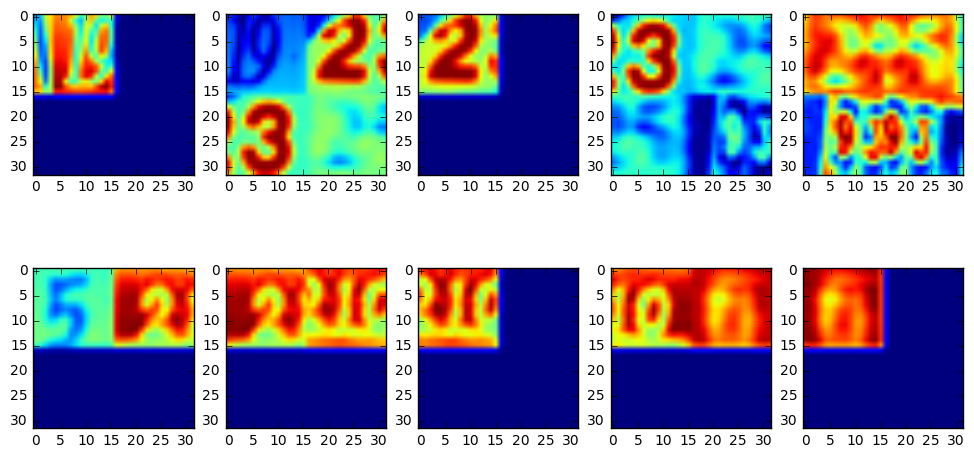

Test Images:52        		21        		1        		06        		6        		


In [108]:
fig = plt.figure(figsize=(12, 6), dpi=72)
x='Training Images:'
for i in range(5):
    for j in y_input[i]:
        if j == 10:
            break
        x = x + str(j)
    x=x+'     \t\t'
print(x)
for i in range(5):
    plt.subplot(2,5,i+1)
    img=X_input[i].reshape(image_size,image_size)
    plt.imshow(img)
    plt.subplot(2,5,i+6)
    img=X_tests[i].reshape(image_size,image_size)
    plt.imshow(img)
plt.show()
x='Test Images:'
for i in range(5):
    for j in y_tests[i]:
        if j == 10:
            break
        x = x + str(j)
    x=x+'        \t\t'
print(x)

### Helper Functions for TensorFlow model

In [38]:
def accuracy(y, labels):
    ntests = labels.shape[0]
    ndigit = labels.shape[1]

    y_pred = np.argmax(y, 2).T
    match=0
    for i in range(ntests):
        match += np.sum(labels[i]==y_pred[i])//ndigit

    label_accuracy = 100.*match/ntests
    digit_accuracy = 100.*np.sum(labels==y_pred)//(ntests*ndigit)
    # return label accuracy as this is the really what we want to make sure was predicted correctly
    return digit_accuracy, label_accuracy

def conv2d(x, W, conv_stride, padopt):
    return tf.nn.conv2d(x, W, strides=[1, conv_stride, conv_stride, 1], padding=padopt)

def max_pool(x, pool_size, pool_stride, padopt):
    return tf.nn.max_pool(x, ksize=[1, pool_size, pool_size, 1], strides=[1, pool_stride, pool_stride, 1], padding=padopt)

# Create Variables Function
def weights_conv(shape, name):
    return tf.get_variable(shape=shape, name=name,
        initializer=tf.contrib.layers.xavier_initializer_conv2d())

def weights_fc(shape, name):
    return tf.get_variable(shape=shape, name=name,
        initializer=tf.contrib.layers.xavier_initializer())

def biases_var(shape, name):
    return tf.Variable(tf.constant(0.1, shape=shape), name=name)

### TensorFlow CNN model

In [39]:
def tf_model (X, weights, biases, nconv, conv_params, dropout=False):
    #initialize relu_logits as the input dataset
    [patch_size, conv_stride, pool_size, pool_stride, padopt] = conv_params
    nlayer = len(weights.keys())
    hidden = X
    # build convolution layers
    for layer in range(nconv):
        hidden = tf.nn.relu(conv2d(hidden, weights[layer], conv_stride, padopt) + biases[layer])
        hidden = max_pool(hidden, pool_size, pool_stride, padopt)
        if (dropout):
            hidden = tf.nn.dropout(hidden, .8)

    shape  = hidden.get_shape().as_list()
    cur_logits = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])

    for layer in range(nconv, nlayer):
        logits = tf.matmul(cur_logits, weights[layer]) + biases[layer]
        # Transform logits computed from layer 1 using relu function to compute logits for layer2
        if layer < nlayer-1:
            cur_logits = tf.nn.relu(logits)
        # Dropout on hidden layers only
            if dropout:
                cur_logits = tf.nn.dropout(cur_logits, 0.8)

    return logits

# Create Function for Image Size: Pooling
# 3 Convolutions
# 2 Max Pooling
# final_image_size = output_size_pool(image_size, patch_size, conv_stride, pool_size, pool_stride, nlayer

def output_size_pool(input_size, conv_filter_size, conv_stride, pool_filter_size, pool_stride, nlayer, padding):

    pad = 1.0 if padding == 'SAME' else 0.0

    output = input_size
    for layer in range(nlayer):
        # After convolution
        output = (((output - conv_filter_size + 2 * pad) / conv_stride) + 1.00)
        # After pool
        output = (((output - pool_filter_size + 2 * pad) / pool_stride) + 1.00)

    return int(output)

def pack(y):
    nitems = len(y.keys())
    if nitems > 5:
        print ("too much to pack")
        y_pack = None
    elif nitems == 5:
        y_pack = tf.stack([y[0],y[1], y[2], y[3], y[4]])
    elif nitems == 4:
        y_pack = tf.stack([y[0],y[1], y[2], y[3]])
    elif nitems == 3:
        y_pack = tf.stack([y[0],y[1], y[2]])
    elif nitems == 2:
        y_pack = tf.stack([y[0],y[1]])
    elif nitems == 1:
        y_pack = y[0]
    else:
        print("nothing to pack")
        y_pack = None

    return y_pack

#Create a single hidden layer neural network using RELU and 1024 nodes
def n_layer_cnn (X_train, y_train, X_valid, y_valid, X_test, y_test, image, num_labels, ndigit, depth, num_hidden,
                conv_params, batch_size=128, num_samples=0, num_steps = 1001, print_steps=100, dropout=False):
    if num_samples ==0:
        num_samples = X_train.shape[0]

    # reshape X_train, X_valid and X_test
    graph = tf.Graph()
    #build nodes array and append it with the number of classes which is final number of nodes

    [patch_size, conv_stride, pool_size, pool_stride, padopt] = conv_params
    image_size = image[0]

    with graph.as_default():

        # Input data. For the training data, we use a placeholder that will be fed
        # at run time with a training minibatch.
        tf_X_train = tf.placeholder(tf.float32, shape=(batch_size, image[0], image[1], image[2]))
        tf_y_train = tf.placeholder(tf.int32, shape=(batch_size, ndigit))
        tf_X_valid = tf.constant(X_valid)
        tf_X_test  = tf.constant(X_test)

        # save weights and biases in a dictionary for each layer
        weights={}
        biases ={}
        logits ={}
        # build weights and biases for each layer for each of the possible 5 digits
        # first dimesion of the weights will be the number of features in the training dataset which is the image size
        loss = 0
        regularizers = 0
        nconv = len(depth)
        nfc   = len(num_hidden)
        nlayer = nconv + nfc + 1

        #build convolution dimensions
        conv_dim = [image[2]] + depth + [num_hidden[0]]
        print ("convolution dimensions", conv_dim)

        # build FC layers dimensions
        final_image_size = output_size_pool(image_size, patch_size, conv_stride, pool_size, pool_stride, len(depth), padopt)
        hidden_dim = [final_image_size*final_image_size*depth[-1]] + num_hidden + [num_labels]
        print ("hidden dimensions", hidden_dim)


        print ('final image size', final_image_size)
        for digit in range(ndigit):
            weights[digit] = {}
            biases[digit]  = {}

            # buld weights and biases for convolution layers first
            for layer in range(nconv):
                shape = [patch_size, patch_size, conv_dim[layer], conv_dim[layer+1]]
                weights[digit][layer] = weights_conv(shape,'w'+str(digit)+str(layer))
                biases[digit][layer]  = biases_var([depth[layer]],'b'+str(digit)+str(layer))
                w_l2_loss = tf.nn.l2_loss(weights[digit][layer])
                regularizers = regularizers + w_l2_loss

            # build weights and biases for fully connected layers next
            for layer in range (nconv,nlayer):
                i = layer - nconv # index to hidden layer
                shape = [hidden_dim[i], hidden_dim[i+1]]
                weights[digit][layer] = weights_fc(shape,'w'+str(digit)+str(layer))
                biases[digit][layer]  = biases_var([hidden_dim[i+1]], 'b'+str(digit)+str(layer))
                w_l2_loss = tf.nn.l2_loss(weights[digit][layer])
                regularizers = regularizers + w_l2_loss

            logits[digit] = tf_model (tf_X_train, weights[digit], biases[digit], nconv, conv_params, dropout)
            loss += tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_y_train[:,digit], logits=logits[digit]))

        # Loss function with L2 Regularization with beta
        beta = 0.0001
        loss = tf.reduce_mean(loss + beta * regularizers)

        # Optimize using Gradient Descent
        global_step = tf.Variable(0)  # count the number of steps taken.
        init_learning_rate = 0.05
        learning_rate = tf.train.exponential_decay(init_learning_rate, global_step, decay_steps=100000, decay_rate=0.95, staircase=True)
        #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
        optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

        # Compute prediction for training samples 
        y_pred={}
        for digit in range(ndigit):
            y_pred[digit] = tf.nn.softmax(logits[digit])

        y_train_pred = pack(y_pred)

        # Transform validation samples using the same transformation used above for training samples
        for digit in range(ndigit):
            valid_logits = tf_model (tf_X_valid, weights[digit], biases[digit], nconv, conv_params, dropout)
            y_pred[digit] = tf.nn.softmax(valid_logits)

        y_valid_pred = pack(y_pred)

        # Transform test samples using the same transformation used above for training samples
        for digit in range(ndigit):
            test_logits = tf_model (tf_X_test, weights[digit], biases[digit], nconv, conv_params, dropout)
            y_pred[digit] = tf.nn.softmax(test_logits)

        y_test_pred = pack(y_pred)


    with tf.Session(graph=graph) as session:
        # This is a one-time operation which ensures the parameters get initialized as
        # we described in the graph: random weights for the matrix, zeros for the
        # biases. 
        tf.global_variables_initializer().run()
        print ('\nstep#       Loss     Training Accuracy Validation Accuracy')

        y_temp       = np.zeros([batch_size, ndigit, num_labels], dtype=np.int32)
        y_valid_temp = np.zeros([y_valid.shape[0], y_valid.shape[1], num_labels], dtype=np.int32)
        y_test_temp  = np.zeros([y_test.shape[0], y_test.shape[1], num_labels], dtype=np.int32)

        for step in range(num_steps):
            offset = (step * batch_size) % (num_samples - batch_size)
            # Generate a minibatch from the training dataset for Stocastic Gradient Descent
            batch_X = X_train[offset:(offset + batch_size), :]
            batch_y = y_train[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_X_train : batch_X, tf_y_train : batch_y}
            _, l, y_pred = session.run([optimizer, loss, y_train_pred], feed_dict=feed_dict)

            # Run the computations. We tell .run() that we want to run the optimizer,
            # and get the loss value and the training predictions returned as numpy arrays.
            if (step % print_steps == 0):
                y_valid_eval = y_valid_pred.eval()
                trn_digit, trn_label = accuracy(y_pred, batch_y)
                val_digit, val_label = accuracy(y_valid_eval, y_valid)
                print('{0:5d} {1:10.2f}        ({2:5.2f},{3:5.2f})     ({4:5.2f},{5:5.2f})'.format(step, l, 
                trn_digit, trn_label, val_digit, val_label))
                # Calling .eval() on valid_prediction is basically like calling run()
        y_test_eval = y_test_pred.eval()
        tst_digit, tst_label = accuracy(y_test_eval, y_test)
        print('Test accuracy: ({:6.2f},{:6.2f})'.format(tst_digit, tst_label))
    return y_test_eval, y_valid_eval

### Results of TensorFlow CNN Model

In [31]:

batch_size  = 64
num_steps   = 5001
print_steps = 500
dropout     = True
num_sample  = 0 # try with full dataset; otherwise specify the subset
patch_size  = 5
conv_stride = 1
pool_size   = 2
pool_stride = 2
padopt      = 'SAME'
conv_params = [patch_size, conv_stride, pool_size, pool_stride, padopt]
depth       = [  8, 16, 32]
num_hidden  = [1024, 256, 32]
num_labels  = 11
num_samples = 0
start_time=time()
y_test_pred, y_valid_pred = n_layer_cnn (X_input, y_input, X_valid, y_valid, X_tests, y_tests, 
                                        image, num_labels, ndigit, depth, num_hidden, conv_params, 
                                        batch_size, num_samples, num_steps, print_steps, dropout)
total_time = time() - start_time
print ("Elapsed time:", total_time)

convolution dimensions [1, 8, 16, 32, 1024]
hidden dimensions [512, 1024, 256, 32, 11]
final image size 4

step#       Loss     Training Accuracy Validation Accuracy
    0      10.43        ( 5.00, 0.00)     (39.00, 2.31)
  500       6.16        (51.00, 6.25)     (48.00, 5.56)
 1000       5.70        (48.00, 4.69)     (50.00, 7.94)
 1500       5.01        (58.00,12.50)     (53.00,10.41)
 2000       5.70        (52.00,14.06)     (56.00,14.62)
 2500       4.96        (57.00,14.06)     (57.00,16.69)
 3000       5.01        (56.00,17.19)     (58.00,17.90)
 3500       4.97        (56.00,12.50)     (59.00,18.66)
 4000       4.80        (56.00,12.50)     (60.00,19.98)
 4500       4.67        (59.00,20.31)     (61.00,21.05)
 5000       4.32        (64.00,17.19)     (62.00,21.77)
Test accuracy: ( 63.00, 22.72)
Elapsed time: 2225.538022994995


### Keras CNN Model and results

In [109]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K

K.set_image_dim_ordering('tf')

def larger_model(input_shape, num_classes, ndigit):
    # create model
    model_input = x = Input(shape=input_shape)
    x = Convolution2D(8, 5, 5, border_mode='valid', input_shape=input_shape, activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Convolution2D(16, 3, 3, activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)

    # build a list of outputs for all digits
    print("number of digits", ndigit)
    outputs=[]
    for i in range(ndigit):
        outputs.append(Dense(num_classes, activation='softmax')(x))

    model = Model(input=model_input, output=outputs)

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

X_train, y_train, X_tests, y_tests, input_shape, num_classes, ndigit = \
                                load_digits_dataset (multi_digit=True, synthetic=True)
# build the model
kcnn_model = larger_model(input_shape, num_classes, ndigit)
# Fit the model using 90% of training data and use remaining for validation
n = round(0.9*X_train.shape[0])
# create a sequence of output labels to compare with the sequence of predictions
yt = []
yv = []
yf = []
for i in range(ndigit):
    yt.append(y_train[:n,i])
    yv.append(y_train[n:,i])
    yf.append(y_tests[:,i])

batch_size = 128
print("batch size", batch_size)
start_time=time()
kcnn_model.fit(X_train[:n], yt, validation_data=(X_train[n:], yv), nb_epoch=20, batch_size=batch_size, verbose=2)
kcnn_model.save('kcnn_model.h5')
# compute true accuracy by comparing all digits in the label
y_pred_kcnn = kcnn_model.predict(X_tests)
total_time = time() - start_time
print ("Elapsed time:", total_time)
digit_accuracy, label_accuracy = accuracy(y_pred_kcnn, y_tests)
print("Digit accuracy: %.2f%%" % digit_accuracy)
print("Label accuracy: %.2f%%" % label_accuracy)

Modeling using multi-digit synthetic data
input shape (32, 32, 1)

DataSet      X Shape,       Y_shape
Training (73257, 32, 32, 1) (73257, 4)
Testing  (26032, 32, 32, 1) (26032, 4)
input shape (32, 32, 1) 4
number of digits 4
batch size 128
Train on 65931 samples, validate on 7326 samples
Epoch 1/20


### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

SVHN dataset consists of 3 groups. Training, testing and extra data. Training set has 33402 samples, testing set has 13068 and extra set has about 230000 samples. Extra set will be used to extend our training set and perform validation during model training. Speaking about possible labels, basically there might be an infinite amount of labels, since there are no limitations about data presented. However, since we are going to work with images which have up to five digits between 1 and 99999 inclusive, this is the amount of all possible labels. Samples which have numbers with more than 5 digits (only 1) were removed from the dataset during preprocessing step. Beside the images, dataset contains also a digitStruct structure which contains some meta information about each image. This structure has same length as amount of images in a dataset (one entry per image). Here each entry has two fields: name which is a string containing the filename of the corresponding image and bbox which is a struct array that contains the position, size and label of each digit bounding box in the image. For instance, digitStruct(300).bbox(2).height gives height of the 2nd digit bounding box in the 300th image.

The second dataset contains single digit images in an MNIST-like format. All digits have been resized to a fixed resolution of 32-by-32 pixels. The original character bounding boxes are extended in the appropriate dimension to become square windows, so that resizing them to 32-by-32 pixels does not introduce aspect ratio distortions. Nevertheless this preprocessing introduces some distracting digits to the sides of the digit of interest. Loading the .mat files creates 2 variables: X which is a 4-D matrix containing the images, and y which is a vector of class labels. To access the images, X(:,:,:,i) gives the i-th 32-by-32 RGB image, with class label y(i). 

In the first part of a project I developd a multilayer convolutional neural network, which will be trained to predict a synthetic data set comprised of the individual digit SVHN dataset in a 2x2 grid to keep aspect ratio of each digit intact (see get_image.py file for the related code).  I used following models to train and validate with the dataset:
1. A 7 layer convolutional neural network using TensorFlow
2. A 7 layer CNN model using Keras with Theano backend

Their respective performance was as follows:

|Model type| Digit Accuracy | Label Accuracy  |Run Time|
|----------|----------------|-----------------|--------|
|TensorFlow CNN|     63%    |       23%       | 2225sec|
|Keras CNN |      83%       |       51%       | 2667sec|


### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_



**Answer:**

** TensorFlow CNN Model **

1. Convolutional layer with 8 feature maps, which with the size of 5×5 and a rectifier activation function. This is the input layer, expecting images with the structure outline above [pixels][width][height].
2. A pooling layer that takes the max called MaxPooling2D. It is configured with a pool size of 2×2.
3. Convolutional layer with 16 feature maps of size 3×3.
4. Pooling layer taking the max over 2*2 patches.
5. Convolutional layer with 32 feature maps of size 3×3.
6. Next is a layer that converts the 2D matrix data to a vector called Flatten. It allows the output to be processed by standard fully connected layers.
4. Next a fully connected layer with 1024 neurons and rectifier activation function.
8. Fully connected layer with 1024 neurons and rectifier activation.
9. Dropout layer with a probability of 20%.
10. Fully connected layer with 256 neurons and rectifier activation.
11. Dropout layer with a probability of 20%.
12. Fully connected layer with 32 neurons and rectifier activation.
13. Output layer with 11 nodes for 11 classes (including blank) with a softmax activation function to output probability-like predictions for each class.

<img src="Convolution.png"> 
<h3><center>A Typical CNN Model</center></h3>

** Keras CNN Model **

1. Convolutional layer with 8 feature maps of size 5×5.
2. Pooling layer taking the max over 2*2 patches.
3. Convolutional layer with 16 feature maps of size 3×3.
4. Pooling layer taking the max over 2*2 patches.
5. Convolutional layer with 32 feature maps of size 3×3.
6. Flatten layer.
7. Dropout layer with a probability of 20%.
8. Fully connected layer with 1024 neurons and rectifier activation.
9. Dropout layer with a probability of 20%.
10. Fully connected layer with 256 neurons and rectifier activation.
11. Dropout layer with a probability of 20%.
12. Fully connected layer with 64 neurons and rectifier activation.
13. Output layer with 11 nodes with a softmax activation to output probability like predictions

<img src="k_cnn_model.png"> 
<h3><center>Keras CNN Model</center></h3>

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**
For both models a synthetic dataset was used, which was already preprocessed and pickled. 

During data preprocessing I implemented these steps:

1. Cropped each image just near the numbers to reduce the size of the model without loosing critical information.
2. Scaled cropped images to 32x32 size since after cropping all images have different sizes.
3. Normalized each pixel RGB value between [-1., 1]
4. Converted all input images into a grayscale by multiplying RGB vector [0.2989, 0.5870, 0.1140]. This also reduces the image from 3 channels to just one which significantly reduces compute time.
5. ‘0’ digit class was replaced from 10 to 0 to be consistent with other digits and classes. Instead, class 10 label is used for non-existing digit. Hence, altogether there are 11 labels.
6. Padded each number with size less than 5 digits, with labels 10 at the end. For example,number 567 will consist of a list sub labels: [5, 6, 7, 10, 10].

I used 90% of the training data for training the model and used remaining for the validation purposes. 


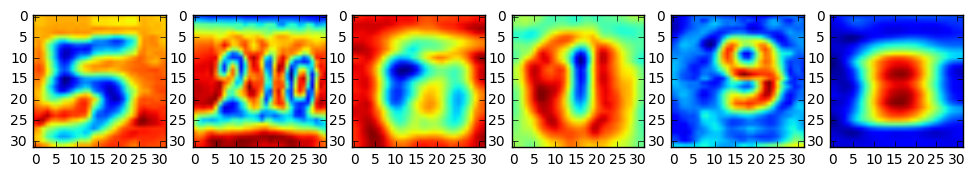

NameError: name 'y_pred_kcnn' is not defined

In [12]:
fig = plt.figure(figsize=(12, 6), dpi=82)
for i in range(6):
    plt.subplot(1,6,i+1)
    img=X_tests[i].reshape(image_size,image_size)
    plt.imshow(img)
plt.show()
#get predicted labels for these images
y=np.argmax(y_pred_kcnn, axis=2).T
x='Predicted:'
for i in range(6):
    for j in y[i]:
        if j == 10:
            break
        x = x + str(j)
    x=x+'\t\t'
print(x)

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### TensorFlow model with Real SVHN Dataset

In [45]:
X_train, y_train, X_tests, y_tests, input_shape, num_classes, ndigit = \
                                load_digits_dataset (multi_digit=True, synthetic=False)
print('\nDataSet      X Shape,       Y_shape')
print('Training', X_train.shape, y_train.shape)
print('Testing ', X_test.shape, y_test.shape)

start_time=time()
# Fit the model using 90% of training data and use remaining for validation
n = round(0.9*X_train.shape[0])
y_test_pred, y_valid_pred = n_layer_cnn (X_train[:n], y_train[:n], X_train[n:], y_train[n:], X_tests, y_tests, 
                                        image, num_labels, ndigit, depth, num_hidden, conv_params, 
                                        batch_size, num_samples, num_steps, print_steps, dropout)
total_time = time() - start_time
print ("Elapsed time:", total_time)

Modeling using multi-digit SVHN data
input shape (32, 32, 1)
convolution dimensions [1, 8, 16, 32, 1024]
hidden dimensions [512, 1024, 256, 32, 11]
final image size 4

step#       Loss     Training Accuracy Validation Accuracy
    0      12.06        (19.00, 0.00)     (58.00, 0.78)
  500       5.39        (67.00, 6.25)     (65.00, 4.43)
 1000       4.21        (74.00,21.09)     (73.00,17.07)
 1500       3.40        (78.00,31.25)     (79.00,32.57)
 2000       3.03        (81.00,39.06)     (82.00,42.19)
 2500       2.79        (84.00,49.22)     (83.00,45.00)
 3000       2.72        (85.00,45.31)     (84.00,49.73)
 3500       3.20        (82.00,51.56)     (84.00,49.49)
 4000       2.26        (88.00,57.03)     (85.00,52.34)
 4500       2.07        (88.00,57.03)     (86.00,56.38)
 5000       2.15        (89.00,58.59)     (86.00,55.18)
Test accuracy: ( 88.00, 56.44)
Elapsed time: 4971.957520484924


### Keras model with Real SVHN Dataset

In [9]:
seed = 7
np.random.seed(seed)
X_train, y_train, X_tests, y_tests, input_shape, num_classes, ndigit = \
                                load_digits_dataset (multi_digit=True, synthetic=False)
print('\nDataSet      X Shape,       Y_shape')
print('Training', X_train.shape, y_train.shape)
print('Testing ', X_tests.shape, y_tests.shape)

Modeling using multi-digit SVHN data
input shape (32, 32, 1)

DataSet      X Shape,       Y_shape
Training (33401, 32, 32, 1) (33401, 5)
Testing  (13068, 32, 32, 1) (13068, 5)
input shape (32, 32, 1) 5

DataSet      X Shape,       Y_shape
Training (33401, 32, 32, 1) (33401, 5)
Testing  (13068, 32, 32, 1) (13068, 5)


In [74]:
start_time=time()
# Fit the model using 90% of training data and use remaining for validation
n = round(0.9*X_train.shape[0])

X_train, y_train, X_tests, y_tests, input_shape, num_classes, ndigit = \
                                load_digits_dataset (multi_digit=True, synthetic=False)
# build the model
k_cnn_model = larger_model(input_shape, num_classes, ndigit)
# Fit the model using 90% of training data and use remaining for validation
n = round(0.9*X_train.shape[0])
# create a sequence of output labels to compare with the sequence of predictions
yt = []
yv = []
yf = []
for i in range(ndigit):
    yt.append(y_train[:n,i])
    yv.append(y_train[n:,i])
    yf.append(y_tests[:,i])

batch_size = 128
print("batch size", batch_size)
start_time=time()
k_cnn_model.fit(X_train[:n], yt, validation_data=(X_train[n:], yv), nb_epoch=20, batch_size=batch_size, verbose=2)
k_cnn_model.save('k_cnn_model.h5')
# compute true accuracy by comparing all digits in the label
y_pred_k_cnn = k_cnn_model.predict(X_tests)
total_time = time() - start_time
print ("Elapsed time:", total_time)
digit_accuracy, label_accuracy = accuracy(y_pred_k_cnn, y_tests)
print("Digit accuracy: %.2f%%" % digit_accuracy)
print("Label accuracy: %.2f%%" % label_accuracy)

Modeling using multi-digit SVHN data
input shape (32, 32, 1)

DataSet      X Shape,       Y_shape
Training (202353, 32, 32, 1) (202353, 5)
Testing  (13068, 32, 32, 1) (13068, 5)
input shape (32, 32, 1) 5
number of digits 5
batch size 128
Train on 182118 samples, validate on 20235 samples
Epoch 1/20
346s - loss: 3.9230 - dense_51_loss: 1.1073 - dense_52_loss: 1.3487 - dense_53_loss: 1.1591 - dense_54_loss: 0.2879 - dense_55_loss: 0.0199 - dense_51_acc: 0.6247 - dense_52_acc: 0.5368 - dense_53_acc: 0.6214 - dense_54_acc: 0.9310 - dense_55_acc: 0.9990 - val_loss: 1.7869 - val_dense_51_loss: 0.4654 - val_dense_52_loss: 0.5499 - val_dense_53_loss: 0.5837 - val_dense_54_loss: 0.1835 - val_dense_55_loss: 0.0044 - val_dense_51_acc: 0.8598 - val_dense_52_acc: 0.8325 - val_dense_53_acc: 0.8203 - val_dense_54_acc: 0.9434 - val_dense_55_acc: 0.9996
Epoch 2/20
361s - loss: 1.8524 - dense_51_loss: 0.4987 - dense_52_loss: 0.5815 - dense_53_loss: 0.5919 - dense_54_loss: 0.1744 - dense_55_loss: 0.0059 

In [10]:
from keras.utils.visualize_util import plot
from keras.models import load_model
k_cnn_model = load_model('k_cnn_model.h5')
plot(k_cnn_model, to_file='k_cnn_model.png')
y_pred_k_cnn = k_cnn_model.predict(X_tests)

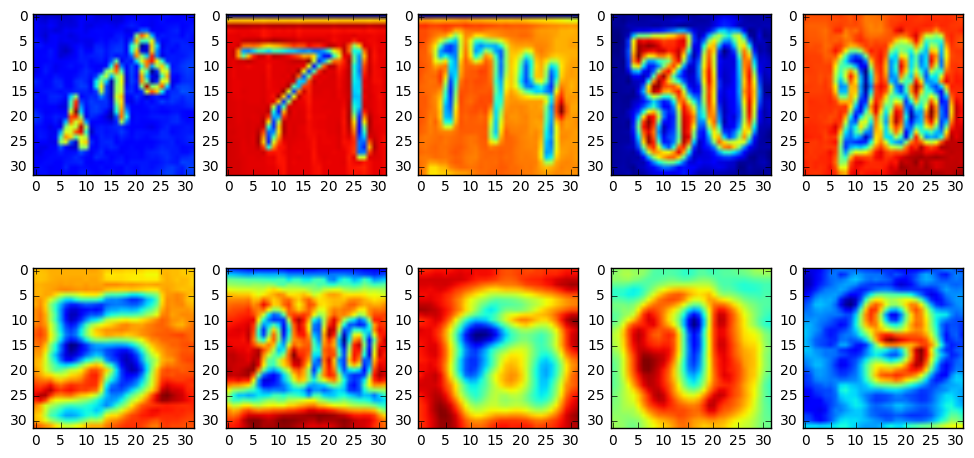

Predicted:5			210			6			0			9			


In [75]:
fig = plt.figure(figsize=(12, 6), dpi=72)
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train[i].reshape(image_size,image_size))
    plt.subplot(2,5,i+6)
    plt.imshow(X_tests[i].reshape(image_size,image_size))
plt.show()
#get predicted labels for these images
y=np.argmax(y_pred_k_cnn, axis=2).T
x='Predicted:'
for i in range(5):
    for j in y[i]:
        if j == 10:
            break
        x = x + str(j)
    x=x+'\t\t\t'
print(x)

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**
This data was also preprocessed following the same steps as for the synthetic data (except no image concatenation).
I created load_digits_dataset() function to load either the single or multi-digit SVHN or synthetic datasets. I used 90% of the training data for training while remaining for validation. The testing data was used only to verify model accuracy to make sure no overfitting happened. The model performed quite well on the real dataset as shown in the table below:

| DataSet |Model type    | Digit Accuracy | Label Accuracy  |Run Time|
|---------|--------------|----------------|-----------------|--------|
|Synthetic|TensorFlow CNN|      63%       |       23%       | 2225sec|
|Synthetic|Keras CNN     |      83%       |       51%       | 2667sec|
|Real SVHN|TensorFlow CNN|      88%       |       56%       | 4972sec|
|Real SVHN|Keras CNN     |      95%       |       82%       | 7224sec|


### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**
The CNN model with TensorFlow performed much better on the real dataset than the synthetic one. This model had independent weights for each digit in the label. However, its accuracy was still quite bad (just 56%) for the label, i.e. when all the digits in the label were identified correctly in the right order. The Keras CNN model worked much better as the layers till the output layer were shared for all output digits. It had to be tuned to improve its accuracy though mostly by running the model for more epochs. The runtime of the Keras model also had a factor of 4 advantage over the TensorFlow model. 

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**
The CNN model using Keras performed much better than the TensorFlow model, and both models performed much better on the real dataset as compared to the synthetic dataset. The table above shows the accuracies of each model for synthetic and real dataset. I believe these results could be improved by increasing depth of the convolution layers. However, I was limited by the memory and cpu on my desktop as higher depth models kept crashing python on my desktop. Besides, each epoch took over 20 mins to complete when it was not crashing. Therefore, with the current limitation of my computing resources I believe I got good results with these models.

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [76]:
import cv2
def get_image(imagefiles):
    nfile = len(imagefiles)
    img = np.zeros((nfile,32,32,1), dtype=np.float32)
    for i in range(nfile):
        image = np.array(cv2.imread(imagefiles[i]), dtype=np.float32)
        image = np.dot(np.array(image, dtype='float32'), [[0.3],[0.587],[0.414]])
        img[i] = image*2/255. -1.0
    return img

### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

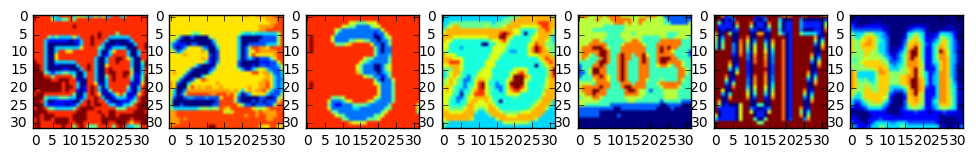

Predicted:50   	  	25   	  	3   	  	76   	  	305   	  	2017   	  	541   	  	


In [88]:
imagefiles =['digit1.bmp', 'digit2.bmp','digit3.bmp','digit4.bmp','digit5.bmp','digit6.bmp', 'digit7.bmp']
img = get_image(imagefiles)
nfiles=len(imagefiles)
fig = plt.figure(figsize=(12, 7), dpi=60)
for i in range(nfiles):
    plt.subplot(1,7,i+1)
    plt.imshow(img[i].reshape(32,32))
plt.show()
y_p = k_cnn_model.predict(img)
y = np.argmax(y_p, axis=2).T
x='Predicted:'
for i in range(nfiles):
    for j in y[i]:
        if j == 10:
            break
        x = x + str(j)
    x=x+'   \t  \t'
print(x)

**Answer:**

I chose these images as they are from around my house and include various digits and label length.

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**
As evident from the answer above, the model was able to predict 7 out 7 numbers correctly, which is pretty good for this model which was restricted due to computing resources. The model seems to have difficulty when the numbers are small as we are limited to a 32x32 image which needs to cram all digits.

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [92]:
def bbox_accuracy(y, labels):
    ntests = labels.shape[0]
    nboxes = labels.shape[1]//4
    y_true = labels.reshape(ntests, nboxes, -1)

    y_pred = np.argmax(y, 2).T
    y_pred = y_pred.reshape(ntests, nboxes, -1)
    match=0
    for i in range(ntests):
        for j in range(nboxes):
            match += np.sum(y_true[i,j]==y_pred[i,j])//4

    bbox_accuracy = 100.*match/ntests/nboxes
    return bbox_accuracy, y_pred

pickle_file = 'SVHN_bboxes.pickle'
print("Modeling using multi-digit SVHN data")
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    X_train = save['train_data']
    y_train = save['train_labels']
    X_tests = save['test_data']
    y_tests = save['test_labels']
    test_files  = save['test_files']
    del save  # hint to help gc free up memory

print('\nDataSet      X Shape,       Y_shape')
print('Training', X_train.shape, y_train.shape)
print('Testing ', X_tests.shape, y_tests.shape)

ndigit = y_tests.shape[1]
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
num_classes = input_shape[0] + 1 # we are going to have output values for each pixel and 0 if none
print ('input shape', input_shape)

# build the model
bbox_model = larger_model(input_shape, num_classes, ndigit)
# Fit the model using 98% of training data and use remaining for validation
n = round(0.98*X_train.shape[0])
# create a sequence of output labels to compare with the sequence of predictions
yt = []
yv = []
yf = []
for i in range(ndigit):
    yt.append(y_train[:n,i])
    yv.append(y_train[n:,i])
    yf.append(y_tests[:,i])

batch_size = 64
print("batch size", batch_size)
start_time=time()
bbox_model.fit(X_train[:n], yt, validation_data=(X_train[n:], yv), nb_epoch=10, batch_size=batch_size, verbose=2)
total_time = time() - start_time
print ("Fitting time:", round(total_time))
k_cnn_model.save('bbox_model.h5')
# compute true accuracy by comparing all digits in the label
y_pred = bbox_model.predict(X_tests)
label_accuracy, bboxes = bbox_accuracy(y_pred, y_tests)
print("Label accuracy: %.2f%%" % label_accuracy)

Modeling using multi-digit SVHN data

DataSet      X Shape,       Y_shape
Training (202353, 50, 50, 1) (202353, 20)
Testing  (13068, 50, 50, 1) (13068, 20)
input shape (50, 50, 1)
number of digits 20
batch size 64
Train on 198306 samples, validate on 4047 samples
Epoch 1/10
1389s - loss: 27.8972 - dense_105_loss: 2.2987 - dense_106_loss: 2.6074 - dense_107_loss: 2.3358 - dense_108_loss: 2.9106 - dense_109_loss: 2.1164 - dense_110_loss: 2.4671 - dense_111_loss: 2.2465 - dense_112_loss: 2.8630 - dense_113_loss: 1.4575 - dense_114_loss: 1.7778 - dense_115_loss: 1.5507 - dense_116_loss: 1.9579 - dense_117_loss: 0.2812 - dense_118_loss: 0.3232 - dense_119_loss: 0.2843 - dense_120_loss: 0.3305 - dense_121_loss: 0.0301 - dense_122_loss: 0.0192 - dense_123_loss: 0.0176 - dense_124_loss: 0.0218 - dense_105_acc: 0.1966 - dense_106_acc: 0.1301 - dense_107_acc: 0.1693 - dense_108_acc: 0.0972 - dense_109_acc: 0.2532 - dense_110_acc: 0.1676 - dense_111_acc: 0.2084 - dense_112_acc: 0.1221 - dense_113

### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

To save computation time, I had to reduce image size to 50x50. The label accuracy for the bounding boxes is 56%, which is not at all satisfactory. However, this may be due to manipulation of the bounding boxes to keep them within image boundary or due to reduction of image which was necessary to keep the compute time reasonable.

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

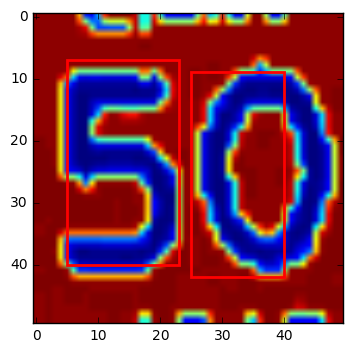

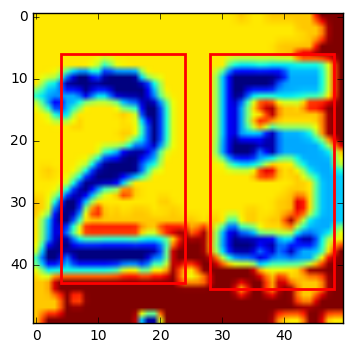

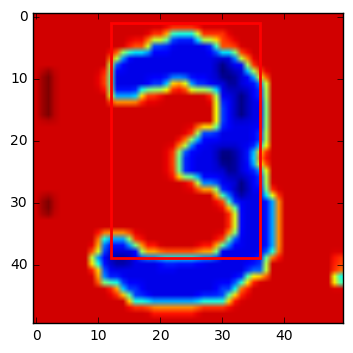

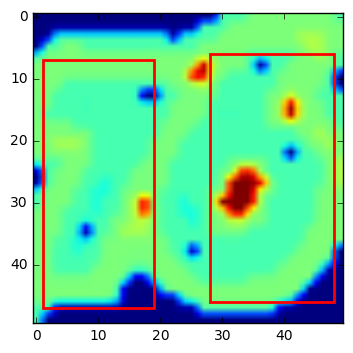

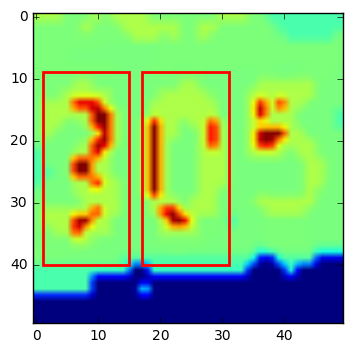

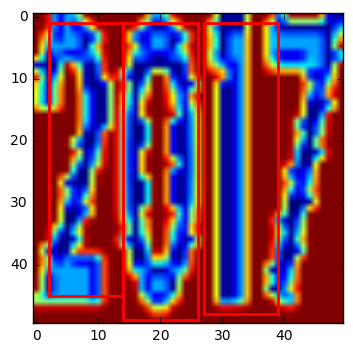

In [93]:
from keras.models import load_model
import matplotlib.patches as patches
from   scipy.misc import imresize
from   PIL import Image
def read_images(imagefiles, image_size):
    nfile = len(imagefiles)
    img = np.zeros((nfile,image_size,image_size,1), dtype=np.float32)
    for i in range(nfile):
        image = cv2.imread(imagefiles[i])
        image = imresize(image,(image_size, image_size))
        image = np.dot(np.array(image, dtype='float32'), [[0.574],[0.575],[0.574]])
        img[i] = 2.*image/255. - 1.0
    return img
def show_bboxes (imagefiles, bboxes, image_size):
    ntests = bboxes.shape[0]
    nboxes = bboxes.shape[1]//4
    bboxes = bboxes.reshape(ntests, nboxes, -1)
    for i, imagefile in enumerate(imagefiles):
        im = np.array(Image.open(imagefile), dtype=np.uint8)
        im = imresize(im,(image_size, image_size))
        fig,ax = plt.subplots(1)
        for j in range(nboxes):
            x,y,w,h = bboxes[i,j]
            if w*h == 0:
                break
            rect = patches.Rectangle((x,y),w,h,linewidth=2, edgecolor='r',facecolor='none')
            ax.add_patch(rect)
        plt.imshow(im)
    plt.show()

bbox_model_file = 'bbox_model.h5'
try:
    model = load_model(bbox_model_file)
except Exception as e:
    print('Unable to load model from file', bbox_model_file, ':', e)
    raise

imagefiles =['digit1.bmp', 'digit2.bmp','digit3.bmp','digit4.bmp','digit5.bmp','digit6.bmp']
img = read_images(imagefiles, input_shape[0])
y_pred = bbox_model.predict(img)
y= np.argmax(y_pred, axis=2).T
show_bboxes(imagefiles, y, input_shape[0])

**Answer:**

The bounding box accuracy is not bad for the sample images despite accuracy of only 58%. It missed one digit each in two images. Once again, I suspect this is largely due to limited image size (50x50) used for regression, which itself is causing each epoch to take over 20mins with a total runtime of nearly 4 hours. Therefore, it would really need a powerful gpu based machine that I don't have to run a model with larger image size in reasonable time.

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [97]:
import cv2
from keras.models import load_model
from   scipy.misc import imresize
import numpy as np
import sys

def read_digits(argv):
    images = len(argv) - 1
    if images == 0:
        print('Usage: {} imagefile1 imagefile2 ...'.format(argv[0]))
        return

    print('Number of images:', images)
    grayscale = [[0.574],[0.575],[0.574]]
    # Load a compiled model identical to the previous one
    model_file = 'k_cnn_model.h5'
    try:
        model = load_model(model_file)
    except Exception as e:
        print('Unable to load model from file', model_file, ':', e)
        raise

    img_size = 32
    ndigit   = 5
    cell = img_size//2

    for imagefile in argv[1:]:
        print('processing image', imagefile)
        # Read the input image as grayscale
        im = cv2.imread(imagefile)
        height, width, channels = im.shape

        im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)        # convert to gray

        # apply Gaussian filtering
        im_gray = cv2.GaussianBlur(im_gray, (5, 5), 0)

        # Threshold the image
        #ret, im_th = cv2.threshold(im_gray, 127, 255, cv2.THRESH_BINARY_INV)
        im_th = cv2.adaptiveThreshold(im_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 31, 10)

        # Find contours in the image
        _, ctrs, hier = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Get rectangles contains each contour
        rects = [cv2.boundingRect(ctr) for ctr in ctrs]
        nrect = len(rects)
        print('found {} digits in the image {}'.format(nrect, imagefile))
        images = np.ndarray([nrect, img_size, img_size, 1], dtype='float32')

        # For each rectangular region, predict digits included (upto 5 supported for now)
        index = 0
        for i, rect in enumerate(rects):
            # Draw bounding box
            x,y,w,h = rect
            if h <= 16 or w <= 16:
                continue

            # Make the rectangular region around the digit and within image boundaries
            x1 = int(x - .1*w)
            x1 = 1 if x1 < 1 else x1
            y1 = int(y - .1*h)
            y1 = 1 if y1 < 1 else y1
            w1 = int(w * 1.2)
            w1 = (width - x1 -1) if (x1+w1) >= width else w1
            h1 = int(h * 1.2)
            h1 = (height -y1 -1) if (y1+h1) >= height else h1
            area = w1*h1
            if (area <= 0):
                print("found degenerate bounding box", x1, y1, w1, h1)
                continue

            img = im_gray[y1:,x1:][:h1,:w1]
            # Resize the image
            img = imresize(img, [img_size, img_size]) # Resize synthetic image to 32x32

            img = cv2.dilate(img, (3, 3))

            img = np.array([img],dtype='float32').reshape(img_size, img_size, -1)
            images[index]= 2*img/255. - 1.0
            rects[index] = x1, y1, w1, h1
            cv2.rectangle(im, (x1,y1), (x1+w1, y1+h1), (0, 255, 0), 2)
            index += 1

        print ("Total valid digits found", index)
        if not index:
            print("No sizable digits found")
            return
        y_pred = model.predict(images[:index])
        yp = np.argmax(y_pred, 2).T

        for i in range(index):
            txt = ''
            x,y,w,h = rects[i]
            xt= x + w//2
            yt = int(y+h)
            for j in yp[i]:
                txt = txt + str(j) if j < 10 else txt
            cv2.putText(im, txt, (xt,yt), cv2.FONT_HERSHEY_SCRIPT_COMPLEX, 2, (255, 0, 0), 1)

        cv2.imshow("Image with Numbers", im)
        cv2.waitKey()

# The following codelines would make this an independent python program (as in file read_digits.py in the same folder)
#if __name__ == "__main__":
#    read_digits(sys.argv)
#the first value is really the name of the program (and not an image as needed by the independent program)
imagefiles= ['read_digits', 'numbers1.bmp','numbers3.bmp','numbers4.bmp']
read_digits(imagefiles)

Number of images: 3
processing image numbers1.bmp
found 10 digits in the image numbers1.bmp
Total valid digits found 10
processing image numbers3.bmp
found 11 digits in the image numbers3.bmp
Total valid digits found 11
processing image numbers4.bmp
found 10 digits in the image numbers4.bmp
Total valid digits found 10


### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

The python program usage is:

>read_digits image1 image2 image3...

1. First, the program loads the machine learning Keras CNN model for classification of digits

The python program reads all specified images (one at a time) and finds the bounding boxes first using the opencv findContours module. For this the image needs to be preprocessed as follows:
2. Converted to grayscale image using cvtColor module using cv2.COLOR_BGR2GRAY filter
3. Applies Gaussian filtering using opencv GaussianBlur module
4. Establishes threshold for finding contours in the image using adaptiveThreshold module
5. Finds outermost contours in the image using findContours module using computed threshold and cv2.RETR_EXTERNAL mode
6. Collects bounding boxes for each contour and saves them for further processing and look up
7. Extends bounding box dimensions to by 10% in both x and y directions
8. Adjusts bounding box dimensions so that the bounding box is inside the specified image
9. Creats a new image by capturing image contents within the bounding box
10. Resizes image to 32x32 size for classification
11. Dialates image to improve recognition of digits
12. Normalizes pixel values within [-1,1] to improve their classification
13. Stores normalized image in the array of images

The following operations are then performed on the prepared sub-images found
14. Predicts digits using the loaded model given the preprocessed images above
15. Gathers predicted digits by performing argmax function on the predictions and taking transform

For each identified digit in the image:
15. Draws bounding box rectangle using the bounding box dimensions
16. Builds text label for each number found in the image
17. Draws text around the bounding box at its bottom middle section

Finally, it shows the resulting image as the output

The aforementioned process is repeated for each input image.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.